In [11]:
# Imports
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.fft import fft, ifft, fftfreq
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.linear_model import LinearRegression
from joblib import Parallel, delayed
from tqdm import tqdm
import pandas as pd
from pandas.tseries.offsets import MonthBegin
pd.set_option('display.float_format', lambda x: '%.3f' % x)

## Hard-Coded Variables 
- uses domain knowledge 

In [12]:
#hardcoded information
expected_groups = {
    ('A', 7),
    ('A', 8),
    ('B', 1),
    ('B', 2),
    ('C', 3),
    ('C', 4),
    ('D', 5),
    ('D', 6),
}

group_1 = {1,2,7,8}
group_2 = {3,4,5,6}
group_1_feature_bounds = {
    "wheeldiameter": (29.0, 41),
    "wheelwidth": (5.50, 5.9),
    "flangeheight": (0.90, 1.55),
    "flangethickness": (0.85, 1.75),
    "flangeslope": (0.10, 0.60),
    "treadhollow": (0.01, 5.3),
    "rimthickness": (0.75, 1.85),
    "backtobackgauge": (52.0, 53.0),
}
group_2_feature_bounds = {
    "wheeldiameter": (29.0, 46.0),
    "wheelwidth": (5.50, 5.87),
    "flangeheight": (0.90, 1.55),
    "flangethickness": (0.85, 1.75),
    "flangeslope": (0.10, 0.60),
    "treadhollow": (0.01, 5.1),
    "rimthickness": (0.80, 2.1),
    "backtobackgauge": (52.0, 53.0),
}

group_2_severity_thresholds = {'backtobackgauge': [(52.0, -5), (52.0, -4), (52.0, -3), (52.0, -2), (52.0, -1),
                     (53.0, 1), (53.0, 2), (53.0, 3), (53.0, 4), (53.0, 5)],
 'flangeheight': [(1.009, -5), (1.027, -4), (1.036, -3), (1.041, -2),
                  (1.057, -1), (1.467, 1), (1.487, 2), (1.492, 3), (1.5, 4),
                  (1.508, 5)],
 'flangeslope': [(0.119, -5), (0.122, -4), (0.124, -3), (0.126, -2),
                 (0.132, -1), (0.505, 1), (0.528, 2), (0.535, 3), (0.544, 4),
                 (0.556, 5)],
 'flangethickness': [(0.878, -5), (0.897, -4), (0.911, -3), (0.924, -2),
                     (0.969, -1), (1.544, 1), (1.572, 2), (1.582, 3),
                     (1.597, 4), (1.62, 5)],
 'rimthickness': [(0.852, -5), (0.868, -4), (0.88, -3), (0.889, -2), (0.92, -1),
                  (1.983, 1), (2.012, 2), (2.021, 3), (2.032, 4), (2.05, 5)],
 'treadhollow': [(0.01, -5), (0.01, -4), (0.01, -3), (0.01, -2), (0.01, -1),
                 (4.029, 1), (4.369, 2), (4.473, 3), (4.601, 4), (4.769, 5)],
 'wheeldiameter': [(29.0, -5), (29.134, -4), (30.0, -3), (30.63, -2),
                   (32.756, -1), (43.622, 1), (44.331, 2), (44.488, 3),
                   (44.724, 4), (45.118, 5)],
 'wheelwidth': [(5.516, -5), (5.526, -4), (5.533, -3), (5.539, -2), (5.554, -1),
                (5.812, 1), (5.831, 2), (5.837, 3), (5.843, 4), (5.852, 5)]}

group_1_severity_thresholds = {
    'backtobackgauge': [(52.0, -5), (52.0, -4), (52.0, -3), (52.0, -2), (52.0, -1),
                     (53.0, 1), (53.0, 2), (53.0, 3), (53.0, 4), (53.0, 5)],
 'flangeheight': [(1.03, -5), (1.044, -4), (1.051, -3), (1.058, -2),
                  (1.072, -1), (1.5, 1), (1.515, 2), (1.52, 3), (1.525, 4),
                  (1.533, 5)],
 'flangeslope': [(0.124, -5), (0.128, -4), (0.13, -3), (0.132, -2), (0.139, -1),
                 (0.52, 1), (0.543, 2), (0.55, 3), (0.559, 4), (0.572, 5)],
 'flangethickness': [(0.879, -5), (0.895, -4), (0.909, -3), (0.92, -2),
                     (0.96, -1), (1.575, 1), (1.604, 2), (1.615, 3), (1.63, 4),
                     (1.653, 5)],
 'rimthickness': [(0.778, -5), (0.796, -4), (0.81, -3), (0.822, -2),
                  (0.866, -1), (1.694, 1), (1.726, 2), (1.736, 3), (1.749, 4),
                  (1.768, 5)],
 'treadhollow': [(0.01, -5), (0.01, -4), (0.01, -3), (0.01, -2), (0.01, -1),
                 (4.196, 1), (4.53, 2), (4.636, 3), (4.757, 4), (4.938, 5)],
 'wheeldiameter': [(30.394, -5), (30.709, -4), (30.945, -3), (31.102, -2),
                   (31.575, -1), (38.976, 1), (39.528, 2), (39.764, 3),
                   (40.0, 4), (40.236, 5)],
 'wheelwidth': [(5.527, -5), (5.537, -4), (5.543, -3), (5.548, -2), (5.563, -1),
                (5.812, 1), (5.833, 2), (5.839, 3), (5.845, 4), (5.853, 5)]
}

geometry_features = ['flangeheight', 'rimthickness', 'wheeldiameter', 'wheelwidth','flangethickness','flangeslope', 'backtobackgauge','treadhollow', 'flangeangle']  


## Initializations
- loading datasets
- filtering invalid values and axles
- merging failure dfs into one

In [13]:
# Functions
def load_data(path_prefix: str = '../Datasets') -> dict:
    """
    Load all required datasets and fill missing failure reasons.
    Returns a dict of DataFrames.
    """
    files = {
        'failure': 'FailureTable0723.csv',
        'equipment': 'equipment_data_masked.csv',
        'mileage': 'Mileage0723.csv',
        'wpd': 'Wpd0723.csv',
    }
    dfs = {name: pd.read_csv(f"{path_prefix}/{fname}", engine='pyarrow') for name, fname in files.items()}
    dfs['failure']['failurereason'] = dfs['failure']['failurereason'].fillna('not failed')
    dfs['wpd']= dfs['wpd'][dfs['wpd']['traindate'] < '2024-12-01']
    return dfs



In [14]:
# merge with failurereason, and applieddate and mileage data
def fast_filter(df, name,valid_axles, feature_bounds):
    before = df.shape
    valid_trucks = {(truck) for (truck, axle) in expected_groups if axle in valid_axles}
    valid_pairs = {(truck, axle) for (truck, axle) in expected_groups if axle in valid_axles}

    if 'axle' not in df.columns:
        mask = df['truck'].isin(valid_trucks)
    else:
        mask = [pair in valid_pairs for pair in zip(df['truck'], df['axle'])]

    df_filtered = df[mask].copy()
    df_filtered[geometry_features + ['trainspeed']] = df_filtered[geometry_features + ['trainspeed']].replace(0, np.nan)
    for feature, (min_val, max_val) in feature_bounds.items():
        if feature in df_filtered.columns:
            too_low = df_filtered[feature] < (0.8 * min_val)
            too_high = df_filtered[feature] > (1.2 * max_val)

            df_filtered.loc[too_low | too_high, feature] = np.nan

            df_filtered.loc[(df_filtered[feature] >= (0.8 * min_val)) & (df_filtered[feature] < min_val), feature] = min_val
            df_filtered.loc[(df_filtered[feature] <= (1.2 * max_val)) & (df_filtered[feature] > max_val), feature] = max_val

    after = df_filtered.shape
    print(f"{name}: before = {before}, after = {after}")
    return df_filtered.reset_index(drop=True)


def fast_filter_by_group(df, name):
    dfs = df.copy()
    print(f"{name}: pre-filter shape: {dfs.shape}")
    df_group_1 = fast_filter(dfs, f"{name} (group1)", group_1, group_1_feature_bounds)
    df_group_2 = fast_filter(dfs, f"{name} (group2)", group_2, group_2_feature_bounds)
    df_combined = pd.concat([df_group_1, df_group_2], ignore_index=True)
    print(f"{name}: combined shape = {df_combined.shape}")

    return df_combined



In [15]:
#load data
dfs = load_data()

In [16]:
df_wpd = fast_filter_by_group(dfs['wpd'], 'wpd')
df_failure = dfs['failure']

wpd: pre-filter shape: (3705464, 17)
wpd (group1): before = (3705464, 17), after = (1804013, 17)
wpd (group2): before = (3705464, 17), after = (1876337, 17)
wpd: combined shape = (3680350, 17)


In [17]:
df_wpd = df_wpd[df_wpd['equipmentnumber'] <= 1]
df_failure = df_failure[df_failure['equipmentnumber'] <= 1]


## Adding applieddates to wpd records

In [18]:
df_wpd['recordmonth'] = df_wpd['traindate'].values.astype('datetime64[M]')
df_wpd['recordmonth_next'] = df_wpd['recordmonth'] + pd.DateOffset(months=1)

# getting rid of duplicates due to vendornumbersuppliercode 
df_failure_temp = df_failure.sort_values('applieddate').drop_duplicates(['equipmentnumber', 'truck', 'axle', 'side', 'recordmonth'])
df_failure_temp['recordmonth'] = pd.to_datetime(df_failure_temp['recordmonth']).values.astype('datetime64[M]')

# merging current month's applieddate
merge_keys = ['equipmentnumber', 'truck', 'axle', 'side', 'recordmonth']
df_wpd = df_wpd.merge(
    df_failure_temp[merge_keys + ['applieddate']],
    on=merge_keys,
    how='left'
)
df_wpd.rename(columns={'applieddate': 'applieddate_initial'}, inplace=True)

# merging next month's applieddate 
merge_keys_next = ['equipmentnumber', 'truck', 'axle', 'side', 'recordmonth_next']
df_wpd = df_wpd.merge(
    df_failure_temp.rename(columns={'recordmonth': 'recordmonth_next', 'applieddate': 'applieddate_next'})[
        merge_keys_next + ['applieddate_next']
    ],
    on=merge_keys_next,
    how='left'
)

# if next months applieddate is before my traindate, I am apart of next month's wheel
df_wpd['applieddate'] = np.where(
    df_wpd['traindate'] >= df_wpd['applieddate_next'],
    df_wpd['applieddate_next'],
    df_wpd['applieddate_initial']
)

df_wpd = df_wpd.drop(columns=['recordmonth_next','applieddate_next','applieddate_initial'])

## Make DF for each wheel
- starts at the applieddate, ends at the day before the next applieddate
- apply FFT, decay-weighted rolling mean, and a combination of the 2 as a polynomial trend to the DF 
- more details in the notes

In [19]:
from numpy.fft import fft, ifft, fftfreq
from scipy.optimize import minimize_scalar
import pywt
from scipy.signal import find_peaks
from scipy.signal import welch
import numpy as np
from numpy.linalg import svd
from PyEMD import CEEMDAN

def eval_peak_metrics(orig, recon, peaks_true=None, height=None, distance=None):
    """
    Compute anomaly-preserving metrics: peak recall & attenuation ratio.
    """
    if peaks_true is None:
        peaks_true, _ = find_peaks(orig, height=height, distance=distance)
    peaks_recon, props = find_peaks(recon, height=height, distance=distance)

    if len(peaks_true) == 0:
        return np.nan, np.nan

    tol = 2  # indices within ±2 accepted
    matched = 0
    attn_ratios = []
    for pt in peaks_true:
        close = np.where(np.abs(peaks_recon - pt) <= tol)[0]
        if len(close) > 0:
            matched += 1
            attn_ratios.append(
                np.mean(recon[peaks_recon[close]]) / (orig[pt] + 1e-12)
            )

    recall = matched / len(peaks_true)
    attenuation = np.mean(attn_ratios) if attn_ratios else np.nan
    return recall, attenuation


def spectral_energy_retention(orig, recon, fs=1.0, band=(1/14, 1/1)):
    """
    Fraction of spectral energy retained in anomaly-relevant band.
    band is in cycles/day (e.g. 1/14 to 1/1 ~ 1-14 day periods).
    """
    f_orig, Pxx_orig = welch(orig, fs=fs, nperseg=min(256, len(orig)))
    f_recon, Pxx_recon = welch(recon, fs=fs, nperseg=min(256, len(recon)))

    band_mask_orig = (f_orig >= band[0]) & (f_orig <= band[1])
    band_mask_recon = (f_recon >= band[0]) & (f_recon <= band[1])

    energy_orig = np.trapz(Pxx_orig[band_mask_orig], f_orig[band_mask_orig])
    energy_recon = np.trapz(Pxx_recon[band_mask_recon], f_recon[band_mask_recon])

    return energy_recon / (energy_recon + energy_orig + 1e-12)


def false_peak_rate(orig, recon, height=None, distance=None):
    """
    Fraction of peaks in recon that are spurious (not in orig).
    """
    peaks_orig, _ = find_peaks(orig, height=height, distance=distance)
    peaks_recon, _ = find_peaks(recon, height=height, distance=distance)

    tol = 2
    false_peaks = 0
    for pr in peaks_recon:
        if len(peaks_orig) == 0 or np.min(np.abs(peaks_orig - pr)) > tol:
            false_peaks += 1

    return false_peaks / (len(recon) + 1e-12)


In [30]:
df_wpd['traindate'] = pd.to_datetime(df_wpd['traindate'])
df_wpd['applieddate'] = pd.to_datetime(df_wpd['applieddate'])
df_wpd = df_wpd.sort_values(by=['equipmentnumber', 'truck', 'axle', 'side', 'applieddate', 'traindate'])

def interpolate_daily_wheels(df, n_jobs=-1):
    group_cols = ['equipmentnumber', 'truck', 'axle', 'side']
    grouped = df.groupby(group_cols)

    tasks = []

    # Prepare tasks: each task = (sub_df, start_date, end_date)
    for group_keys, group_df in grouped:
        subgroups = group_df.groupby('applieddate')
        sub_keys_sorted = sorted(subgroups.groups.keys())

        for i, adate in enumerate(sub_keys_sorted):
            sub_df = subgroups.get_group(adate).copy()
            start_date = sub_df['applieddate'].min()
            if start_date < pd.to_datetime('2020-01-01'):
                start_date = pd.to_datetime('2020-01-01')
            if i + 1 < len(sub_keys_sorted):
                next_applieddate = sub_keys_sorted[i + 1]
                end_date = pd.to_datetime(next_applieddate) - pd.Timedelta(days=1)
            else:
                end_date = pd.NaT

            tasks.append((sub_df, start_date, end_date))

    # Wrap the processing function
    def process_task(sub_df, start_date, end_date):
        return signal_process_wheel(sub_df, start_date, end_date)

    results = Parallel(n_jobs=n_jobs)(
        delayed(process_task)(sub_df, start, end)
        for sub_df, start, end in tqdm(tasks, desc="Parallel wheel processing")
    )

    def chunked_concat(dfs, chunk_size=1000):
        chunks = [pd.concat(dfs[i:i+chunk_size], ignore_index=True)
                  for i in range(0, len(dfs), chunk_size)]
        return pd.concat(chunks, ignore_index=True)

    return chunked_concat(results)


def signal_process_wheel(df, start_date, end_date):
    # column definition
    static_cols = ['equipmentnumber', 'truck', 'axle', 'side', 'applieddate']
    monthly_cols = ['siteid', 'direction', 'trainspeed']

    # if no end date, that means it never updates again so end is the end of march
    if pd.isna(end_date):
        end_date = pd.to_datetime('2024-11-30')

    # making the df with static cols
    date_range = pd.date_range(start=start_date, end=end_date, freq='D')
    static_values = {col: df.iloc[0][col] for col in static_cols}
    base_df = pd.DataFrame(date_range, columns=['traindate'])
    for col, val in static_values.items():
        base_df[col] = val

    # merging the monthly rows from the main set
    df_subset = df[['traindate'] + monthly_cols + geometry_features].copy()
    df_subset = df_subset.sort_values('traindate', ascending=False)  # keep latest per day
    df_subset['traindate'] = pd.to_datetime(df_subset['traindate']).dt.normalize()
    df_subset = df_subset.drop_duplicates(subset='traindate')

    merged_df = pd.merge(base_df, df_subset, on='traindate', how='left')

    # forward-fill back fill monthly rows
    #merged_df[monthly_cols] = merged_df[monthly_cols].ffill().bfill()

    # go through each feature for FFT + rolling + poly analysis
    for feat in geometry_features:
        merged_df = merged_df.copy()
        df_feat = merged_df[['traindate', feat]].copy()
        df_feat[feat] = df_feat[feat].replace(0, np.nan)
        df_feat = df_feat.dropna().sort_values('traindate')

        # --- handle trivial cases ---
        if len(df_feat) < 3:
            merged_df[f'{feat}_original'] = np.nan
            for suffix in ["lowpass", "loess", "ema","gpr","kalman","l1trend"]:
                merged_df[f'{feat}_{suffix}'] = np.nan
                merged_df[f'{feat}_{suffix}_param1'] = np.nan
                merged_df[f'{feat}_{suffix}_score'] = np.nan
            for suffix in ["ssa"]:
                merged_df[f'{feat}_{suffix}'] = np.nan
                merged_df[f'{feat}_{suffix}_param1'] = np.nan
                merged_df[f'{feat}_{suffix}_param2'] = np.nan
                merged_df[f'{feat}_{suffix}_score'] = np.nan
            continue

        # --- data prep ---
        x = (df_feat['traindate'] - start_date).dt.days.values
        y = df_feat[feat].values
        max_days = (end_date - start_date).days

        x_uniform = np.linspace(x.min(), max_days, len(x))
        y_interp = np.interp(x_uniform, x, y)

        x_days_full = (date_range - start_date).days.values
        original_daily = np.interp(x_days_full, x, y)

        x_min, x_max = x.min(), x.max()

        # =======================================================
        # FFT HIGHPASS (short-term residual reconstruction)
        # =======================================================

        # --- objective function (maximize anomaly fidelity) ---
        def objective_fft_highpass(cutoff):
            n = len(x_uniform)
            d = x_uniform[1] - x_uniform[0]
            freqs = fftfreq(n, d=d)

            Y = fft(y_interp)
            Y_high = Y.copy()
            Y_high[np.abs(freqs) < cutoff] = 0   # remove low freqs, keep high
            highpass = np.real(ifft(Y_high))

            highpass_daily = np.interp(x_days_full, x_uniform, highpass)

            # mask outside observed range
            highpass_daily[x_days_full < x_min] = np.nan
            highpass_daily[x_days_full > x_max] = np.nan
            orig_masked = original_daily.copy()
            orig_masked[x_days_full < x_min] = np.nan
            orig_masked[x_days_full > x_max] = np.nan

            # --- evaluation metrics (only fair ones) ---
            peak_recall, attn_ratio = eval_peak_metrics(orig_masked, highpass_daily)
            spec_reten = spectral_energy_retention(orig_masked, highpass_daily, fs=1.0, band=(1/14,1/1))
            fpr = false_peak_rate(orig_masked, highpass_daily)

            # --- combine into a single objective ---
            # want: HIGH recall, HIGH attenuation, HIGH spectral, LOW false peaks
            score = (
                + 2.0 * (peak_recall if not np.isnan(peak_recall) else 0.0)
                + 2.0 * (attn_ratio if not np.isnan(attn_ratio) else 0.0)
                + 0.5 * (spec_reten if not np.isnan(spec_reten) else 0.0)
                - 1.0 * fpr
            )

            return -score  # negative because minimize_scalar minimizes


        # --- optimize cutoff ---
        res_fft = minimize_scalar(objective_fft_highpass, bounds=(0.0001, 0.1), method="bounded")
        best_cutoff_fft = res_fft.x
        best_score_fft = -res_fft.fun

        # --- reconstruct highpass with best cutoff ---
        n = len(x_uniform)
        d = x_uniform[1] - x_uniform[0]
        freqs = fftfreq(n, d=d)
        Y = fft(y_interp)
        Y[np.abs(freqs) < best_cutoff_fft] = 0
        highpass = np.real(ifft(Y))
        best_series_fft = np.interp(x_days_full, x_uniform, highpass)

        # mask outside observed range
        best_series_fft[x_days_full < x_min] = np.nan
        best_series_fft[x_days_full > x_max] = np.nan
        original_daily[x_days_full < x_min] = np.nan
        original_daily[x_days_full > x_max] = np.nan

        # --- save FFT HIGHPASS result ---
        merged_df[f'{feat}_original'] = original_daily
        merged_df[f'{feat}_highpass'] = best_series_fft
        merged_df[f'{feat}_highpass_param1'] = best_cutoff_fft
        merged_df[f'{feat}_highpass_score'] = best_score_fft


        # =======================================================
        # EMD RESIDUAL (original minus low-frequency IMFs)
        # =======================================================
        try:
            from PyEMD import EMD
        except ImportError as e:
            raise ImportError("PyEMD is required for EMD residuals. Install with `pip install PyEMD`.") from e

        emd = EMD()
        imfs = emd.emd(y_interp)  # shape: (num_imfs, N)

        if imfs is None or imfs.size == 0:
            best_series_emd = np.full_like(original_daily, np.nan, dtype=float)
            merged_df[f'{feat}_emd'] = best_series_emd
            merged_df[f'{feat}_emd_param1'] = np.nan
            merged_df[f'{feat}_emd_score'] = np.nan
        else:
            num_imfs = imfs.shape[0]

            # --- objective: choose R = number of low-frequency IMFs to REMOVE ---
            def objective_emd_rank(r_float):
                R = int(np.clip(round(r_float), 1, num_imfs))
                # trend = sum of the *last* R IMFs
                y_trend = np.sum(imfs[-R:, :], axis=0)
                # residual = original - trend
                y_hp = y_interp - y_trend

                highpass_daily = np.interp(x_days_full, x_uniform, y_hp[:len(x_uniform)])

                # mask outside observed range
                highpass_daily[x_days_full < x_min] = np.nan
                highpass_daily[x_days_full > x_max] = np.nan
                orig_masked = original_daily.copy()
                orig_masked[x_days_full < x_min] = np.nan
                orig_masked[x_days_full > x_max] = np.nan

                # metrics
                peak_recall, attn_ratio = eval_peak_metrics(orig_masked, highpass_daily)
                spec_reten = spectral_energy_retention(orig_masked, highpass_daily, fs=1.0, band=(1/14, 1/1))
                fpr = false_peak_rate(orig_masked, highpass_daily)

                score = (
                    + 2.0 * (peak_recall if not np.isnan(peak_recall) else 0.0)
                    + 2.0 * (attn_ratio if not np.isnan(attn_ratio) else 0.0)
                    + 0.5 * (spec_reten if not np.isnan(spec_reten) else 0.0)
                    - 1.0 * (fpr if not np.isnan(fpr) else 0.0)
                )
                return -score

            # --- optimize R (low-frequency IMFs to remove) ---
            res_emd = minimize_scalar(objective_emd_rank, bounds=(1, num_imfs), method="bounded")
            best_R = int(np.clip(round(res_emd.x), 1, num_imfs))
            best_score_emd = -res_emd.fun

            # --- reconstruct with best R ---
            y_trend_best = np.sum(imfs[-best_R:, :], axis=0)
            y_hp_best = y_interp - y_trend_best

            best_series_emd = np.interp(x_days_full, x_uniform, y_hp_best[:len(x_uniform)])

            # mask outside observed range
            best_series_emd[x_days_full < x_min] = np.nan
            best_series_emd[x_days_full > x_max] = np.nan
            original_daily[x_days_full < x_min] = np.nan
            original_daily[x_days_full > x_max] = np.nan

            # --- save EMD result ---
            merged_df[f'{feat}_emd'] = best_series_emd
            merged_df[f'{feat}_emd_param1'] = best_R          # number of IMFs removed
            merged_df[f'{feat}_emd_score'] = best_score_emd

        # =======================================================
        # SSA (Singular Spectrum Analysis) HIGHPASS RECONSTRUCTION
        # =======================================================

        def _ssa_hankelize(y, L):
            """
            Build the trajectory (Hankel) matrix of shape (L, K) from 1D series y.
            """
            N = len(y)
            K = N - L + 1
            return np.column_stack([y[i:i+L] for i in range(K)])  # (L, K)

        def _ssa_diagonal_averaging(X):
            """
            Anti-diagonal (Hankel) averaging to go from matrix back to 1D series.
            """
            L, K = X.shape
            N = L + K - 1
            y = np.zeros(N, dtype=float)
            w = np.zeros(N, dtype=float)
            for i in range(L):
                for j in range(K):
                    y[i + j] += X[i, j]
                    w[i + j] += 1.0
            return y / np.maximum(w, 1e-12)

        def _ssa_lowrank_recon(y, L, r):
            """
            Reconstruct the LOW-frequency (trend/seasonal) part using the first r SSA components.
            """
            X = _ssa_hankelize(y, L)                      # (L, K)
            U, s, Vt = np.linalg.svd(X, full_matrices=False)
            r = max(1, min(r, len(s)))                    # safety
            # Low-rank approximation using first r components
            Xr = np.zeros_like(X)
            for i in range(r):
                Xr += s[i] * np.outer(U[:, i], Vt[i, :])
            # Back to 1D
            y_low = _ssa_diagonal_averaging(Xr)
            # Trim/Pad to original length
            return y_low[:len(y)]

        # Choose an SSA window length (L). Good starting point: a bit larger than your longest "trend" cycle.
        # You can set this explicitly if you like; here we pick something reasonable from the data length.
        N = len(y_interp)
        L_ssa = int(np.clip(round(min(max(30, N // 6), N // 2 - 1)), 2, max(2, N-1)))

        # --- objective function (maximize anomaly fidelity) ---
        def objective_ssa_rank(rank_float):
            # rank is the number of leading components to REMOVE (i.e., model as low-freq).
            # We'll reconstruct low-freq with first r comps, then take residual = high-pass.
            r = int(np.clip(round(rank_float), 1, min(L_ssa, N - L_ssa + 1)))  # 1..min(L,K)

            # low-frequency reconstruction and high-pass residual
            y_low = _ssa_lowrank_recon(y_interp, L=L_ssa, r=r)
            y_hp = y_interp - y_low

            # align to daily grid
            highpass_daily = np.interp(x_days_full, x_uniform, y_hp[:len(x_uniform)])

            # mask outside observed range
            highpass_daily[x_days_full < x_min] = np.nan
            highpass_daily[x_days_full > x_max] = np.nan
            orig_masked = original_daily.copy()
            orig_masked[x_days_full < x_min] = np.nan
            orig_masked[x_days_full > x_max] = np.nan

            # --- evaluation metrics ---
            peak_recall, attn_ratio = eval_peak_metrics(orig_masked, highpass_daily)
            spec_reten = spectral_energy_retention(orig_masked, highpass_daily, fs=1.0, band=(1/14, 1/1))
            fpr = false_peak_rate(orig_masked, highpass_daily)

            # combine into single score (same weights as your latest wavelet block)
            score = (
                + 2.0 * (0.0 if np.isnan(peak_recall) else peak_recall)
                + 1.0 * (0.0 if np.isnan(attn_ratio) else attn_ratio)
                + 0.5 * (0.0 if np.isnan(spec_reten) else spec_reten)
                - 1.0 * (0.0 if np.isnan(fpr) else fpr)
            )
            return -score  # minimize -> maximize score

        # --- optimize rank (number of low-freq comps to remove) ---
        # bounds are floats; we round inside the objective
        max_rank = min(L_ssa, N - L_ssa + 1)  # r ≤ number of singular values available
        res_ssa = minimize_scalar(objective_ssa_rank, bounds=(1, max_rank), method="bounded")
        best_rank = int(np.clip(round(res_ssa.x), 1, max_rank))
        best_score_ssa = -res_ssa.fun

        # --- reconstruct with best rank ---
        y_low_best = _ssa_lowrank_recon(y_interp, L=L_ssa, r=best_rank)
        y_hp_best = y_interp - y_low_best
        best_series_ssa = np.interp(x_days_full, x_uniform, y_hp_best[:len(x_uniform)])

        # mask outside observed range
        best_series_ssa[x_days_full < x_min] = np.nan
        best_series_ssa[x_days_full > x_max] = np.nan
        original_daily[x_days_full < x_min] = np.nan
        original_daily[x_days_full > x_max] = np.nan

        # --- save SSA result ---
        merged_df[f'{feat}_ssa'] = best_series_ssa
        merged_df[f'{feat}_ssa_param1'] = best_rank         # number of leading SSA components removed
        merged_df[f'{feat}_ssa_param2'] = L_ssa           # window length used (for reproducibility)
        merged_df[f'{feat}_ssa_score'] = best_score_ssa

        # =======================================================
        # SPLINE (penalized smoothing) HIGHPASS RECONSTRUCTION
        # =======================================================
        # Density-aware smoothing spline on irregular samples; residual is the short-term signal
        from scipy.interpolate import UnivariateSpline

        # --- density-aware weights so dense clusters don't dominate ---
        x_arr = x.astype(float)
        if len(x_arr) >= 3:
            dx = np.diff(x_arr)
            dx_left = np.r_[dx[0], dx]
            dx_right = np.r_[dx, dx[-1]]
            spacing = 0.5 * (dx_left + dx_right)              # proxy for "support" per point
        elif len(x_arr) == 2:
            spacing = np.array([x_arr[1] - x_arr[0]] * 2, dtype=float)
        else:
            spacing = np.ones_like(x_arr, dtype=float)

        # In UnivariateSpline, larger weights => more influence. Give sparse regions larger weight.
        w = spacing / max(spacing.mean(), 1e-12)
        w = np.clip(w, 1e-3, 1e3)

        # Scale the smoothing factor to data variability to keep search stable
        var_y = np.var(y) if len(y) > 1 else 1.0
        scale = max(var_y, 1e-12) * max(len(x_arr), 1)

        # --- objective function (maximize anomaly fidelity) ---
        def objective_spline(log10_s):
            s_val = float(10.0 ** log10_s) * scale  # search in log space for robustness
            try:
                spl = UnivariateSpline(x_arr, y, w=w, s=s_val, k=3)  # cubic smoothing spline
                trend_uniform = spl(x_uniform)
            except Exception:
                return np.inf  # infeasible settings are penalized

            resid_uniform = y_interp - trend_uniform
            resid_daily = np.interp(x_days_full, x_uniform, resid_uniform)

            # mask outside observed range
            resid_daily[x_days_full < x_min] = np.nan
            resid_daily[x_days_full > x_max] = np.nan
            orig_masked = original_daily.copy()
            orig_masked[x_days_full < x_min] = np.nan
            orig_masked[x_days_full > x_max] = np.nan

            # evaluation metrics (same style as your FFT block)
            peak_recall, attn_ratio = eval_peak_metrics(orig_masked, resid_daily)
            spec_reten = spectral_energy_retention(orig_masked, resid_daily, fs=1.0, band=(1/14, 1/1))
            fpr = false_peak_rate(orig_masked, resid_daily)

            score = (
                + 2.0 * (peak_recall if not np.isnan(peak_recall) else 0.0)
                + 2.0 * (attn_ratio if not np.isnan(attn_ratio) else 0.0)
                + 0.5 * (spec_reten if not np.isnan(spec_reten) else 0.0)
                - 1.0 * fpr
            )
            return -score  # minimize -> maximize score

        # --- optimize smoothing factor ---
        res_spline = minimize_scalar(objective_spline, bounds=(-3.0, 3.0), method="bounded")
        best_log10s = res_spline.x
        best_s = (10.0 ** best_log10s) * scale
        best_score_spline = -res_spline.fun

        # --- reconstruct residual with best smoothing ---
        try:
            spl_best = UnivariateSpline(x_arr, y, w=w, s=best_s, k=3)
            trend_uniform_best = spl_best(x_uniform)
        except Exception:
            # very rare fallback: linear interp trend on uniform grid
            trend_uniform_best = np.interp(x_uniform, x_arr, y)

        resid_uniform_best = y_interp - trend_uniform_best
        best_series_spline = np.interp(x_days_full, x_uniform, resid_uniform_best)

        # mask outside observed range
        best_series_spline[x_days_full < x_min] = np.nan
        best_series_spline[x_days_full > x_max] = np.nan

        # --- save SPLINE result ---
        merged_df[f'{feat}_spline'] = best_series_spline
        merged_df[f'{feat}_spline_param1'] = best_s            # smoothing factor actually used
        merged_df[f'{feat}_spline_score'] = best_score_spline

        # =======================================================
        # KALMAN (local linear state-space) HIGHPASS RECONSTRUCTION
        # =======================================================

        def _robust_R_from_diffs(y):
            """Robust variance estimate of measurement noise based on first differences."""
            y = np.asarray(y, float)
            if y.size < 3:
                v = np.var(y) if y.size else 1.0
                return max(v, 1e-6)
            diffs = np.diff(y)
            med = np.median(diffs)
            mad = np.median(np.abs(diffs - med))
            sigma = 1.4826 * mad
            if not np.isfinite(sigma) or sigma < 1e-12:
                sigma = np.sqrt(np.var(diffs) + 1e-12)
            return float(max(sigma**2, 1e-6))


        def _kalman_smoother_local_linear(x_obs, y_obs, q_over_R, R,
                                        dt_cap=180.0, jitter=1e-9):
            """
            Local-linear trend model with RTS smoother.
            Returns smoothed level at observation times.
            Numerically stabilized (dt clamp, Joseph update, jitter, pinv).
            """
            x_obs = np.asarray(x_obs, float)
            y_obs = np.asarray(y_obs, float)
            n = len(x_obs)
            if n == 0:
                return np.array([])
            I = np.eye(2)
            H = np.array([[1.0, 0.0]])

            # init (diffuse-ish)
            var_scale = max(np.var(y_obs), 1.0)
            m = np.zeros((n, 2), float)
            P = np.zeros((n, 2, 2), float)
            m_pred = np.zeros((n, 2), float)
            P_pred = np.zeros((n, 2, 2), float)

            m_prior = np.array([y_obs[0], 0.0], float)
            P_prior = var_scale * np.diag([1e6, 1e6])

            R_eff = float(max(R, 1e-6))

            for k in range(n):
                if k == 0:
                    m_pred[k] = m_prior
                    P_pred[k] = P_prior + jitter * I
                else:
                    dt = float(max(x_obs[k] - x_obs[k-1], 1e-9))
                    dt = min(dt, dt_cap)  # clamp large gaps
                    A = np.array([[1.0, dt],
                                [0.0, 1.0]], float)
                    dt2, dt3 = dt*dt, dt*dt*dt
                    Q = q_over_R * R_eff * np.array([[dt3/3.0, dt2/2.0],
                                                    [dt2/2.0, dt      ]], float)

                    m_pred[k] = A @ m[k-1]
                    P_pred[k] = A @ P[k-1] @ A.T + Q
                    P_pred[k] += jitter * I

                # measurement update (Joseph form)
                S = float(P_pred[k][0, 0] + R_eff)
                if not np.isfinite(S) or S < 1e-12:
                    S = 1e-12
                K = (P_pred[k] @ H.T).ravel() / S  # (2,)
                innov = y_obs[k] - (H @ m_pred[k]).item()
                m[k] = m_pred[k] + K * innov

                KH = np.outer(K, H)               # 2x2
                I_KH = I - KH
                P[k] = I_KH @ P_pred[k] @ I_KH.T + np.outer(K, K) * R_eff
                P[k] += jitter * I

            # RTS smoother
            ms = m.copy()
            Ps = P.copy()
            for k in range(n-2, -1, -1):
                dt = float(max(x_obs[k+1] - x_obs[k], 1e-9))
                dt = min(dt, dt_cap)
                A = np.array([[1.0, dt],
                            [0.0, 1.0]], float)
                Pp = P_pred[k+1] + jitter * I

                # smoothing gain with pseudo-inverse (robust)
                C = P[k] @ A.T @ np.linalg.pinv(Pp, rcond=1e-12)
                ms[k] = m[k] + C @ (ms[k+1] - m_pred[k+1])
                Ps[k] = P[k] + C @ (Ps[k+1] - Pp) @ C.T
                Ps[k] += jitter * I

            return ms[:, 0]  # smoothed level


        # irregular observation grid (actual measurement days)
        x_arr = x.astype(float)
        y_arr = y.astype(float)

        # robust measurement noise variance
        R_var = _robust_R_from_diffs(y_arr)

        # --- objective over log10(q/R) ---
        def objective_kalman(log10_q_over_R):
            q_over_R = float(10.0 ** log10_q_over_R)
            try:
                trend_obs = _kalman_smoother_local_linear(x_arr, y_arr, q_over_R, R_var)
            except Exception:
                return np.inf
            resid_obs = y_arr - trend_obs
            resid_daily = np.interp(x_days_full, x_arr, resid_obs)

            # mask outside observed range
            resid_daily[x_days_full < x_min] = np.nan
            resid_daily[x_days_full > x_max] = np.nan
            orig_masked = original_daily.copy()
            orig_masked[x_days_full < x_min] = np.nan
            orig_masked[x_days_full > x_max] = np.nan

            peak_recall, attn_ratio = eval_peak_metrics(orig_masked, resid_daily)
            spec_reten = spectral_energy_retention(orig_masked, resid_daily, fs=1.0, band=(1/14, 1/1))
            fpr = false_peak_rate(orig_masked, resid_daily)

            score = (
                + 2.0 * (peak_recall if not np.isnan(peak_recall) else 0.0)
                + 2.0 * (attn_ratio if not np.isnan(attn_ratio) else 0.0)
                + 0.5 * (spec_reten if not np.isnan(spec_reten) else 0.0)
                - 1.0 * fpr
            )
            return -score

        # --- optimize q/R ratio ---
        res_kal = minimize_scalar(objective_kalman, bounds=(-4.0, 2.0), method="bounded")
        best_log10_q_over_R = res_kal.x
        best_ratio = 10.0 ** best_log10_q_over_R
        best_score_kalman = -res_kal.fun

        # --- reconstruct with best ratio (guarded) ---
        try:
            trend_best = _kalman_smoother_local_linear(x_arr, y_arr, best_ratio, R_var)
            resid_best = y_arr - trend_best
            best_series_kalman = np.interp(x_days_full, x_arr, resid_best)
        except Exception:
            # graceful fallback: no Kalman for this feature/segment
            best_series_kalman = np.full_like(x_days_full, np.nan, dtype=float)
            best_log10_q_over_R = np.nan
            best_score_kalman = np.nan

        # --- save KALMAN result ---
        merged_df[f'{feat}_kalman'] = best_series_kalman
        merged_df[f'{feat}_kalman_param1'] = best_log10_q_over_R   # log10(q/R)
        merged_df[f'{feat}_kalman_param2'] = R_var                 # measurement noise var
        merged_df[f'{feat}_kalman_score'] = best_score_kalman

        # =======================================================
        # L1 TREND FILTERING (fused-lasso) HIGHPASS RECONSTRUCTION
        #   Solve: min_z 0.5||y - z||_2^2 + λ ||D2 z||_1
        #   High-pass = y - z*
        # =======================================================
        from scipy.sparse import diags, eye, csc_matrix
        from scipy.sparse.linalg import splu

        def _robust_scale_vec(v):
            v = np.asarray(v, float)
            med = np.median(v)
            mad = np.median(np.abs(v - med))
            sigma = 1.4826 * mad
            if not np.isfinite(sigma) or sigma < 1e-8:
                sigma = np.std(v)
                if not np.isfinite(sigma) or sigma < 1e-8:
                    sigma = 1.0
            return (v - med) / sigma, med, sigma

        def _l1_trendfilter_admm(y_u, lam, rho=1.0, max_iter=500, tol=1e-4):
            """
            ADMM for 1D L1 trend filtering on uniform grid:
              min_z 0.5||y - z||_2^2 + lam ||D2 z||_1
            Returns z* (low-pass trend).
            """
            y_u = np.asarray(y_u, float)
            n = y_u.size
            if n < 3:
                return y_u.copy()

            # Second-difference operator D2: shape (n-2, n)
            D2 = diags([1.0, -2.0, 1.0], [0, 1, 2], shape=(n-2, n)).tocsc()
            DT = D2.transpose()

            # Precompute solver for z-update: (I + rho * D2^T D2) z = y + rho * D2^T (v - u)
            A = (eye(n, format='csc') + rho * (DT @ D2)).tocsc()
            # Regularize diagonal slightly for numerical stability
            A = A + diags([1e-6] * n, 0, format='csc')
            lu = splu(A)  # factorization reused across iterations

            # Initialize
            z = y_u.copy()
            v = D2 @ z
            u = np.zeros_like(v)

            # ADMM loop
            for _ in range(max_iter):
                # z-update (quadratic): (I + rho D^T D) z = y + rho D^T (v - u)
                b = y_u + rho * (DT @ (v - u))
                z_new = lu.solve(b)

                # v-update (soft-threshold on D2 z + u)
                Dz = D2 @ z_new
                t = Dz + u
                v_new = np.sign(t) * np.maximum(np.abs(t) - lam / rho, 0.0)

                # u-update (dual)
                u_new = u + Dz - v_new

                # convergence check
                r = Dz - v_new
                s = rho * (DT @ (v_new - v))
                r_norm = np.linalg.norm(r)
                s_norm = np.linalg.norm(s)

                z, v, u = z_new, v_new, u_new
                if r_norm < tol * np.sqrt(n) and s_norm < tol * np.sqrt(n):
                    break

            return z

        # --- prep on uniform grid ---
        yu, y_med, y_sig = _robust_scale_vec(y_interp)  # robust standardization for stable λ search
        n_u = len(yu)
        if n_u < 3:
            # should not happen here because you gate earlier, but extra safety:
            merged_df[f'{feat}_l1trend'] = np.nan
            merged_df[f'{feat}_l1trend_param1'] = np.nan
            merged_df[f'{feat}_l1trend_score'] = np.nan
        else:
            # Coarse-to-moderate λ grid in log10 space (dimensionless because yu is standardized)
            log10_lams = np.linspace(-3.0, 3.0, 13)  # 1e-3 ... 1e3
            best_score_l1 = -np.inf
            best_loglam = None
            best_resid_u = None

            for loglam in log10_lams:
                lam = 10.0 ** loglam
                try:
                    z_trend_u = _l1_trendfilter_admm(yu, lam=lam, rho=1.0, max_iter=600, tol=1e-4)
                except Exception:
                    continue  # skip ill-conditioned cases (unlikely with this setup)

                # Residual on uniform grid in ORIGINAL units
                resid_u = (yu - z_trend_u) * y_sig  # median cancels out

                # Interp residual to daily grid
                resid_daily = np.interp(x_days_full, x_uniform, resid_u)

                # mask outside observed range
                resid_daily[x_days_full < x_min] = np.nan
                resid_daily[x_days_full > x_max] = np.nan
                orig_masked = original_daily.copy()
                orig_masked[x_days_full < x_min] = np.nan
                orig_masked[x_days_full > x_max] = np.nan

                # Evaluate with your existing metrics
                peak_recall, attn_ratio = eval_peak_metrics(orig_masked, resid_daily)
                spec_reten = spectral_energy_retention(orig_masked, resid_daily, fs=1.0, band=(1/14, 1/1))
                fpr = false_peak_rate(orig_masked, resid_daily)

                score = (
                    + 2.0 * (0.0 if np.isnan(peak_recall) else peak_recall)
                    + 2.0 * (0.0 if np.isnan(attn_ratio) else attn_ratio)
                    + 0.5 * (0.0 if np.isnan(spec_reten) else spec_reten)
                    - 1.0 * (0.0 if np.isnan(fpr) else fpr)
                )

                if np.isfinite(score) and score > best_score_l1:
                    best_score_l1 = score
                    best_loglam = loglam
                    best_resid_u = resid_u

            # Fall back if none evaluated (edge cases)
            if best_resid_u is None:
                best_resid_u = (yu - _l1_trendfilter_admm(yu, lam=1.0)) * y_sig
                best_loglam = 0.0
                # build daily residual for saving
            best_series_l1 = np.interp(x_days_full, x_uniform, best_resid_u)
            best_series_l1[x_days_full < x_min] = np.nan
            best_series_l1[x_days_full > x_max] = np.nan

            # --- save L1 TREND result ---
            merged_df[f'{feat}_l1trend'] = best_series_l1
            merged_df[f'{feat}_l1trend_param1'] = 10.0 ** (best_loglam if best_loglam is not None else 0.0)  # λ on standardized scale
            merged_df[f'{feat}_l1trend_score'] = best_score_l1
            # If you also want the low-pass trend itself:
            # z_trend_best = _l1_trendfilter_admm(yu, lam=10**best_loglam) * y_sig + y_med
            # merged_df[f'{feat}_l1trend_trend'] = np.interp(x_days_full, x_uniform, z_trend_best)

    # dropping raw cols as we now have _original cols
    #merged_df = merged_df.drop(columns=geometry_features)
    merged_df['days'] = (pd.to_datetime(merged_df['traindate']) - pd.to_datetime(start_date)).dt.days
    return merged_df

In [31]:
full_wpd = interpolate_daily_wheels(df_wpd, -1)
#full_wpd.to_feather('wpd_trend_null.feather')

Parallel wheel processing: 100%|██████████| 38/38 [00:08<00:00,  4.64it/s]


In [32]:
def compute_signal_metrics(full_wpd, geometry_features, type, param1, use_param2=False, anomaly_labels=None):
    results = []

    for feat in geometry_features:
        orig = full_wpd[f"{feat}_original"].values
        recon = full_wpd[f"{feat}_{type}"].values

        mask = ~np.isnan(orig) & ~np.isnan(recon)
        if mask.sum() < 3:
            metrics = dict(
                peak_recall=np.nan,
                attenuation_ratio=np.nan,
                spectral_retention=np.nan,
                false_peak_rate=np.nan
            )
        else:
            # Peak recall & attenuation
            peak_recall, attn_ratio = eval_peak_metrics(orig[mask], recon[mask])

            # Spectral energy retention (example band: 1–14 days)
            # normalized [0,1]
            spec_reten = spectral_energy_retention(orig[mask], recon[mask], fs=1.0, band=(1/14,1/1))

            # False peak rate
            fpr = false_peak_rate(orig[mask], recon[mask])

            metrics = dict(
                peak_recall=peak_recall,
                attenuation_ratio=attn_ratio,
                spectral_retention=spec_reten,
                false_peak_rate=fpr
            )

        # param1 always present
        param1_val = full_wpd[f"{feat}_{type}_param1"].dropna().mean()
        record = {"feature": feat, "param1": param1_val}

        if use_param2:
            param2_val = full_wpd[f"{feat}_{type}_param2"].dropna().mean()
            record["param2"] = param2_val

        record.update(metrics)
        results.append(record)

    return pd.DataFrame(results).set_index("feature")


for type in ["highpass","emd","spline","l1trend"]:
    summary = compute_signal_metrics(full_wpd, geometry_features, type, "param1")
    print(type)
    display(summary)   # pretty df display

for type in ['ssa','kalman']:
    print(type)
    summary = compute_signal_metrics(full_wpd, geometry_features, type, "param1", use_param2=True)
    display(summary)


highpass


,param1,peak_recall,attenuation_ratio,spectral_retention,false_peak_rate
feature,,,,,
flangeheight,0.048,0.296,0.009,0.072,0.020
rimthickness,0.057,0.247,0.013,0.033,0.014
wheeldiameter,0.073,0.157,0.018,0.014,0.009
wheelwidth,0.081,0.130,0.003,0.007,0.006
flangethickness,0.046,0.296,0.012,0.033,0.019
flangeslope,0.082,0.117,0.035,0.009,0.005
backtobackgauge,0.077,0.243,0.004,0.009,0.006
treadhollow,0.091,0.106,0.179,0.022,0.003
flangeangle,0.100,0.000,NaN,0.000,0.000


emd


,param1,peak_recall,attenuation_ratio,spectral_retention,false_peak_rate
feature,,,,,
flangeheight,2.536,0.312,0.012,0.048,0.011
rimthickness,2.440,0.277,0.019,0.036,0.010
wheeldiameter,2.553,0.214,0.034,0.031,0.007
wheelwidth,2.618,0.237,0.005,0.050,0.007
flangethickness,2.744,0.296,0.021,0.086,0.011
flangeslope,2.376,0.233,0.061,0.045,0.008
backtobackgauge,1.860,0.212,0.006,0.036,0.004
treadhollow,1.804,0.233,0.161,0.037,0.007
flangeangle,1.875,0.053,0.066,0.070,0.001


spline


,param1,peak_recall,attenuation_ratio,spectral_retention,false_peak_rate
feature,,,,,
flangeheight,202.227,0.297,0.013,0.043,0.010
rimthickness,132.197,0.293,0.023,0.560,0.010
wheeldiameter,3657.219,0.234,0.036,0.059,0.008
wheelwidth,1.622,0.231,0.008,0.988,0.008
flangethickness,65.098,0.311,0.027,0.101,0.010
flangeslope,16.680,0.243,0.071,0.093,0.007
backtobackgauge,120.007,0.233,0.006,0.029,0.006
treadhollow,2815.163,0.250,0.257,0.129,0.008
flangeangle,213405.445,0.133,0.074,0.145,0.004


l1trend


,param1,peak_recall,attenuation_ratio,spectral_retention,false_peak_rate
feature,,,,,
flangeheight,2.510,0.355,0.007,0.010,0.013
rimthickness,3.725,0.333,0.013,0.018,0.012
wheeldiameter,7.369,0.283,0.019,0.016,0.010
wheelwidth,17.915,0.271,0.004,0.026,0.008
flangethickness,3.682,0.351,0.011,0.024,0.014
flangeslope,12.282,0.277,0.052,0.031,0.008
backtobackgauge,11.766,0.254,0.005,0.020,0.006
treadhollow,9.350,0.284,0.176,0.071,0.007
flangeangle,14.228,0.167,0.048,0.122,0.003


ssa


,param1,param2,peak_recall,attenuation_ratio,spectral_retention,false_peak_rate
feature,,,,,,
flangeheight,11.516,26.938,0.325,0.007,0.013,0.019
rimthickness,10.807,26.155,0.315,0.011,0.015,0.018
wheeldiameter,10.368,24.375,0.275,0.017,0.013,0.017
wheelwidth,8.553,24.305,0.266,0.003,0.016,0.014
flangethickness,7.533,26.938,0.321,0.015,0.043,0.016
flangeslope,9.382,24.000,0.271,0.037,0.011,0.014
backtobackgauge,10.095,25.567,0.323,0.003,0.011,0.011
treadhollow,7.370,16.856,0.284,0.116,0.015,0.012
flangeangle,3.578,9.565,0.140,0.047,0.081,0.005


kalman


,param1,param2,peak_recall,attenuation_ratio,spectral_retention,false_peak_rate
feature,,,,,,
flangeheight,-2.859,0.001,0.944,0.012,0.269,0.005
rimthickness,-3.373,0.003,0.958,0.020,0.359,0.003
wheeldiameter,-1.846,1.657,0.930,0.023,0.394,0.005
wheelwidth,-3.023,0.002,0.937,0.005,0.456,0.003
flangethickness,-2.946,0.003,0.930,0.018,0.349,0.005
flangeslope,-2.995,0.002,0.956,0.061,0.438,0.003
backtobackgauge,-2.345,0.331,0.566,0.009,0.453,0.010
treadhollow,-3.458,0.239,0.917,0.146,0.235,0.003
flangeangle,-3.134,8.503,0.847,0.031,0.217,0.003


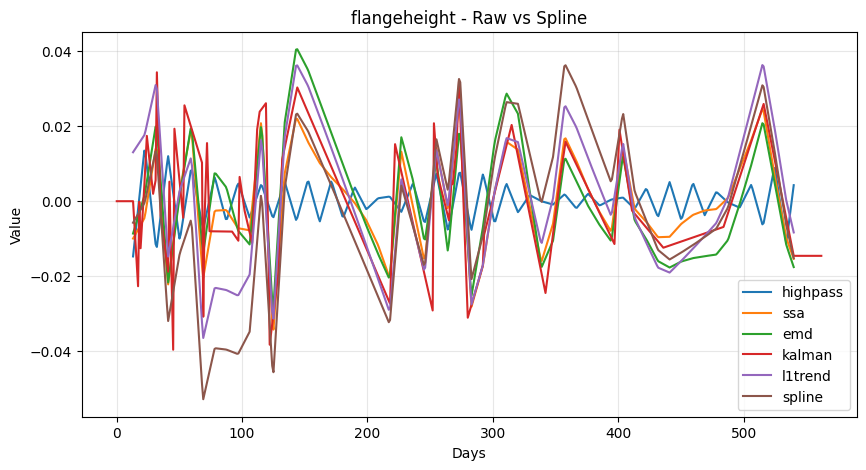

In [43]:
import matplotlib.pyplot as plt
temp = full_wpd[(full_wpd['equipmentnumber'] == 1) & (full_wpd['axle'] == 1) & (full_wpd['side'] == 'L')]['applieddate'].unique()
temp = full_wpd[(full_wpd['equipmentnumber'] == 1) & (full_wpd['axle'] == 1) & (full_wpd['side'] == 'L') & (full_wpd['applieddate'] == temp[1])]
# make sure we have days (if not already in full_wpd)
if "days" not in temp.columns:
    temp["days"] = (temp["traindate"] - temp["traindate"].min()).dt.days

signal = "spline"
# find all features that have a lowpass
features = [c.replace(f"_{signal}", "") for c in temp.columns if c.endswith(f"_{signal}")]

for feat in features:
    raw_col   = f"{feat}"
    signal_col    = f"{feat}_{signal}"

    if raw_col not in temp or signal_col not in temp:
        continue

    plt.figure(figsize=(10, 5))
    #plt.scatter(temp["days"], temp[raw_col], label="Raw", alpha=0.3)
    plt.plot(temp["days"], temp[f'{feat}_highpass'], label='highpass')
    plt.plot(temp["days"], temp[f'{feat}_ssa'], label='ssa')
    plt.plot(temp["days"], temp[f'{feat}_emd'], label='emd')
    plt.plot(temp["days"], temp[f'{feat}_kalman'], label='kalman')
    plt.plot(temp["days"], temp[f'{feat}_l1trend'], label='l1trend')
    plt.plot(temp["days"], temp[f'{feat}_spline'], label='spline')

    plt.title(f"{feat} - Raw vs {signal.capitalize()}")
    plt.xlabel("Days")
    plt.ylabel("Value")
    plt.legend()
    plt.grid(alpha=0.3)
    plt.show()
    break
